- Basic setup to simulate trajectories with 3 parameters (drift, bound, starting point) using Euler Mayurama  method
	- Obtain histograms and psychometrics
	- Compare to analytic solutions, explore the error of the approximation with dt
	- Explore dependence of histograms and psychometrics with parameter values
- Add time varying bound, variability in parameters
- Explore race models

- "Optogenetic manipulations"
	- "Sensory neurons" vs "Integrator neurons"
	- Bound "deletion"
        - Other ways?

- History effects
	- Explore updates on starting point and drifts
	- Also post error slowing (increase bounds after errors)

In [11]:
# @title Import packages
import numpy as np
import matplotlib.pyplot as plt
import importlib
# import all functions defined in ddm.py
import ddm

# set the font size of plots
font = {'size'   : 14}
plt.rc('font', **font)

In [12]:
# Reload all functions from the ddm.py file
# use after making changes in ddm.py.
importlib.reload(ddm)

<module 'ddm' from '/Users/marcocolnaghi/Documents/INCDP/Classes/DecisionMaking/indp22-ddm-simulation-project/code/ddm.py'>

In [13]:
# Define DDM parameters
mu = 0.5 # drift
theta = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
b = 0 # time varying bound

# Define simulation parameters
n_trials = 1000
dt = .001
T = 10

In [14]:
# Run single Simulation
S, hits, errs, thetas, traj = ddm.sim_ddm(mu, theta, b, z, sigma, n_trials, dt, T)

In [15]:
bins = np.linspace(0, 6, 30)
t = np.arange(0, T, dt)

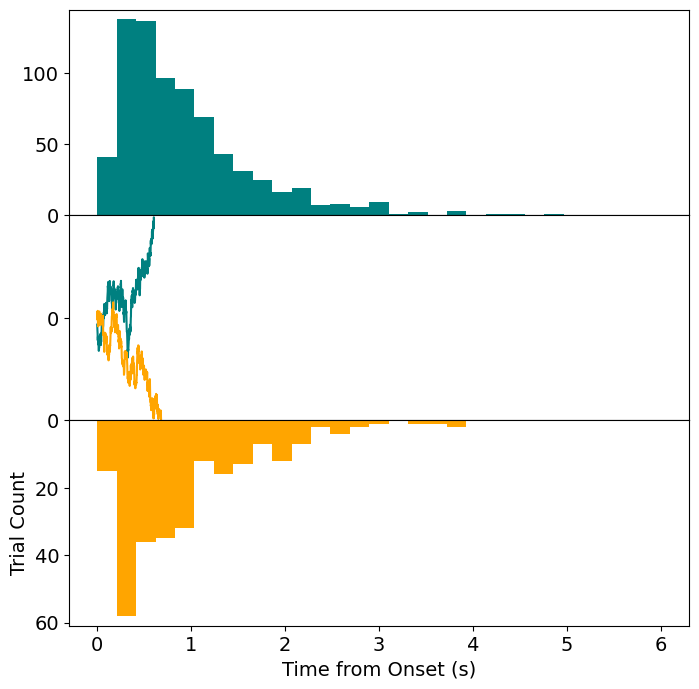

In [16]:
# Plot Trajectories with RT histograms
ddm.plot_trajectories_and_RT(S, hits, errs, traj, t, bins)


In [17]:
# Run DDM simulations for different drifts
n_mu = 21
mu_list = 2*np.linspace(-1, 1, n_mu)
z_list = 0*np.concatenate((-np.ones((10,)),\
                              np.zeros((1,)),\
                              np.ones((10,))))
b = 0.0
# Preallocate results
S_list = []
hits_list = []
errs_list = []
for i, mu in enumerate(mu_list):
    z = z_list[i]
    # Simulate trajectories
    S, hits, errs, thetas, traj = ddm.sim_ddm(mu, theta, b, z, sigma, n_trials, dt, T)
    S_list.append(S)
    hits_list.append(hits)
    errs_list.append(errs)

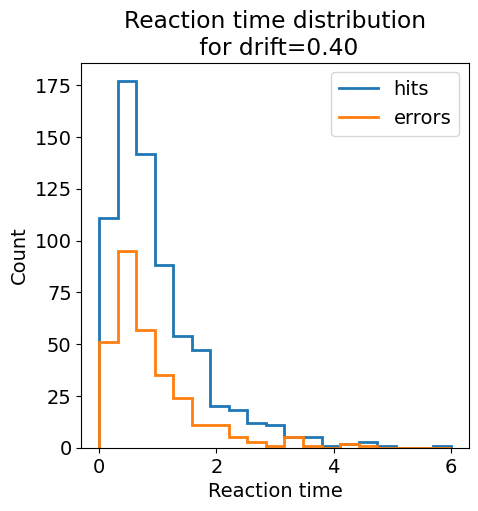

In [18]:
# Plot the reaction time distributions for the hit and error trials, for example mu
mu_i = 12 # example mu
bins = np.linspace(0, 6, 20)

hits = S_list[mu_i][hits_list[mu_i],1]
errs = S_list[mu_i][errs_list[mu_i],1]

ddm.plot_rt_hist(hits, errs, bins)
plt.title('Reaction time distribution\n for drift={:.2f}'.format(mu_list[mu_i]))
plt.show()

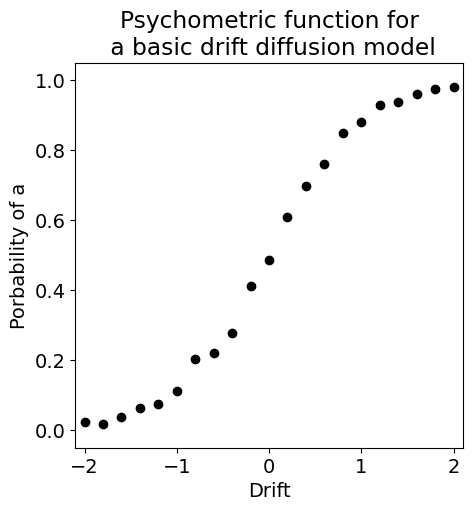

In [19]:
# Plot a psychometric curve
prob_a = ddm.calc_psychometric(S_list, mu_list)
ddm.plot_psychometric(prob_a, mu_list)
plt.title('Psychometric function for\n a basic drift diffusion model')
plt.show()

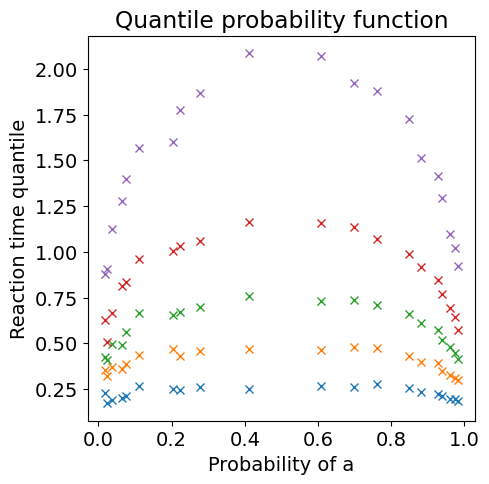

In [20]:
# Plot the quantile probability function
ddm.plot_quantile_prob_func(S_list, hits_list, errs_list, mu_list, prob_a)
plt.title('Quantile probability function')
plt.show()

In [ ]:
# Plot different Bounds
S, hits, errs, thetas, traj = ddm.sim_ddm(mu, theta, b, z, sigma, n_trials, dt, T)

In [99]:
# Run DDM simulations for different drifts
n_bs = 4
bs_list = np.linspace(0.02,0, n_bs)
z_list = 0*np.concatenate((-np.ones((10,)),\
                              np.zeros((1,)),\
                              np.ones((10,))))
mu = 0.2;
# Preallocate results
S_list = []
hits_list = []
errs_list = []
t = np.arange(0, T, dt)
n_t = t.size
trajs = np.zeros((n_trials, n_t, n_bs)); 

for i, b in enumerate(bs_list):
    z = z_list[i]
    # Simulate trajectories
    S, hits, errs, thetas, trajs[:,:,i] = ddm.sim_ddm(mu, theta, b, z, sigma, n_trials, dt, T)
    
    S_list.append(S)
    hits_list.append(hits)
    errs_list.append(errs)
    

In [89]:
thetas = theta/(1+(b/dt*np.linspace(0, 1, n_t)))

In [111]:
hits_list[1][0][1]

3

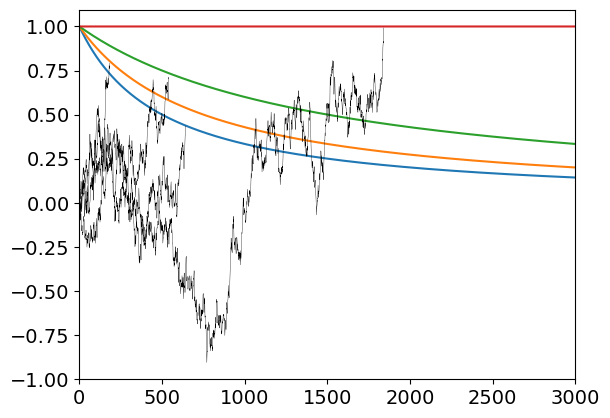

In [118]:
for i, b in enumerate(bs_list):
    thetas = theta/(1+(b/dt*np.linspace(0, 1, n_t)))
    ranget = np.sum(~np.isnan(np.squeeze(trajs[hits_list[i][0][6],:,i])))
    plt.plot(thetas)
    plt.plot(trajs[hits_list[i][0][6],0:ranget,i], color='black', linewidth=0.25)
    plt.xlim([0, 3000])

In [ ]:
bins = np.linspace(0, 6, 30)

In [ ]:
plt.hist(S[:,1],bins);
plt.xlabel('Reaction Time (s)');
plt.ylabel('Trial Count');


In [ ]:
correct = np.where(S[:,0]==1)[0]
incorrect = np.where(S[:,0]==0)[0]

traj[trialExample[1],:]

In [ ]:
trialExample = [correct[4], incorrect[5]]
ranget = [np.sum(~np.isnan(traj[trialExample[0],:])), np.sum(~np.isnan(traj[trialExample[1],:]))]

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,10))

#axes[0].subplots_adjust(hspace=0)
axes[0].hist(S[correct,1], bins,density=True, color='teal');

axes[1].plot(t[0:ranget[0]], traj[trialExample[0],0:ranget[0]].T,color='teal');
axes[1].plot(t[0:ranget[1]], traj[trialExample[1],0:ranget[1]].T,color='orange');
axes[1].set_ylim([-1, 1])
axes[2].hist(S[incorrect,1], bins, density=True,color='orange');
axes[2].invert_yaxis()
plt.subplots_adjust(hspace=0)

#plt.xlabel('Reaction Time (s)');
#plt.ylabel('Trial Count');

In [ ]:
plt.plot(traj[incorrect,:].T);

In [ ]:
ds_traj = traj[:, np.arange(0,n_t,50)]

In [ ]:
plt.plot(ds_traj[incorrect,:].T);

In [ ]:
histbins = np.linspace(-1,1,20)
plt.hist(ds_traj[incorrect,1].T, histbins, alpha = 0.5);
plt.hist(ds_traj[incorrect,6].T, histbins, alpha = 0.5);
plt.hist(ds_traj[incorrect,11].T, histbins, alpha = 0.5);
plt.hist(ds_traj[incorrect,16].T, histbins, alpha = 0.5);